# Imports

In [167]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_directml
from torch.utils.data import Dataset
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import scipy
from scipy.stats import zscore
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import pandas as pd
import numpy as np
import kagglehub
from kagglehub import KaggleDatasetAdapter
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning) # TODO: Actually optimize the source of this warning
simplefilter(action='ignore', category=FutureWarning)
simplefilter("ignore", UserWarning)

# Pytorch Model

In [168]:
# Device configuration, this is to check if GPU is available and run on GPU
# device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
# print(f"Using {device} device")
# We use torch_directml.device() to grab the first DirectX12 capable GPU.
device = torch_directml.device()
print(f"Using device: {device}")

Using device: privateuseone:0


In [169]:
CR_TO_IDX = {
    0: 0, 0.125: 1, 0.25: 2, 0.5: 3,
    1: 4, 2: 5, 3: 6, 4: 7, 5: 8, 6: 9, 7: 10, 8: 11, 9: 12, 10: 13,
    11: 14, 12: 15, 13: 16, 14: 17, 15: 18, 16: 19, 17: 20, 18: 21,
    19: 22, 20: 23, 21: 24, 22: 25, 23: 26, 24: 27, 25: 28, 26: 29,
    27: 30, 28: 31, 29: 32, 30: 33
}

IDX_TO_CR = {
    0: 0, 1: 0.125, 2: 0.25, 3: 0.5, 4: 1, 5: 2, 6: 3, 7: 4, 8: 5, 9: 6, 
    10: 7, 11: 8, 12: 9, 13: 10, 14: 11, 15: 12, 16: 13, 17: 14, 18: 15, 
    19: 16, 20: 17, 21: 18, 22: 19, 23: 20, 24: 21, 25: 22, 26: 23, 27: 24, 
    28: 25, 29: 26, 30: 27, 31: 28, 32: 29, 33: 30
}

crs = [
    0, 0.125, 0.25, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 
    11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 
    24, 25, 26, 27, 28, 29, 30
]

indices = [
    0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
    15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 
    28, 29, 30, 31, 32, 33
]

class MonsterDataset(Dataset):
    def __init__(self, csv_file, train, train_val=.9, transform=None, shuffle=True):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.CAT_COLS = ['size','alignment','type','legendary']
        self.NONNUMERIC_COLS = ['size','alignment','type','legendary','name','attributes','actions','legendary_actions']
        # Add CR mapping
        self.CR_TO_IDX = {
            0: 0, 0.125: 1, 0.25: 2, 0.5: 3,
            1: 4, 2: 5, 3: 6, 4: 7, 5: 8, 6: 9, 7: 10, 8: 11, 9: 12, 10: 13,
            11: 14, 12: 15, 13: 16, 14: 17, 15: 18, 16: 19, 17: 20, 18: 21,
            19: 22, 20: 23, 21: 24, 22: 25, 23: 26, 24: 27, 25: 28, 26: 29,
            27: 30, 28: 31, 29: 32, 30: 33
        }
        self.__parsecsv__(csv_file)
        if shuffle:
            self.df = self.df.sample(frac=1,random_state=796).reset_index(drop=True)


        if train:
            self.df = self.df.iloc[1:int(self.df.shape[0]*train_val)+1].reset_index(drop=True)
        else:
            self.df = self.df.iloc[int(self.df.shape[0]*train_val):self.df.shape[0]].reset_index(drop=True)

        # Create sub dfs of categorized data
        df_size = self.create_subdf("size")
        df_type = self.create_subdf("type")
        df_align = self.create_subdf("alignment")
        df_legend = self.create_subdf("legendary")

        cols_to_drop = list(df_size.columns) + list(df_type.columns) + \
                       list(df_align.columns) + list(df_legend.columns) + \
                       ['name', 'cr']
        # Only drop columns that actually exist to avoid errors
        cols_to_drop = [c for c in cols_to_drop if c in self.df.columns]
        df_numeric = self.df.drop(cols_to_drop, axis=1)

        # Convert everything to Tensors NOW
        # .values converts pandas to numpy, which creates tensors much faster
        self.names = self.df['name'].values

        self.data_size = torch.tensor(df_size.values, dtype=torch.long)
        self.data_type = torch.tensor(df_type.values, dtype=torch.long)
        self.data_align = torch.tensor(df_align.values, dtype=torch.long)
        self.data_legend = torch.tensor(df_legend.values, dtype=torch.long)

        # Pre-calculate targets
        self.data_numeric = torch.tensor(df_numeric.values, dtype=torch.float32)# Map the CR values to indices using a list comprehension or map
        targets = self.df['cr'].map(self.CR_TO_IDX).fillna(0).values 
        self.data_targets = torch.tensor(targets, dtype=torch.long)

        self.transform = transform
    
    def __parsecsv__(self, csv_file):
        self.df_original = pd.read_csv(csv_file)
        self.df = self.df_original.copy()
        self.original_categorical_vals = pd.DataFrame()

        self.__reclassify_categorical__('size')
        self.__reclassify_categorical__('alignment')
        self.__reclassify_categorical__('type')
        self.__reclassify_categorical__('legendary')
        self.__reclassify_list__('languages', ", ")
        self.__reclassify_list__('senses', ", ")

        # temporary removing of string values so I can work only on num values
        self.df = self.df.drop(['attributes','actions','legendary_actions'],axis=1)
        # remove source because these don't contribute anything
        self.df = self.df.drop(['source'],axis=1)
        
        self.__redefine_datatypes__()

        for col in self.CAT_COLS:
            self.dummify_cat_values(col)
        
    def dummify_cat_values(self, col):
        df_copy = self.df.copy()
        if col != 'alignment':
            dummies = pd.get_dummies(df_copy[col],prefix=col).astype('float32')
            df_copy = pd.concat([df_copy,dummies],axis=1)
        else:
            alignments = df_copy[col].str.split(",").tolist()
            flat_align = [col+"_"+item for sublist in alignments for item in sublist]
            set_align = set(flat_align)
            unique_align = list(set_align)
            df_copy = df_copy.reindex(df_copy.columns.tolist() + unique_align, axis=1, fill_value=0)
            # for each value inside column, update the dummy
            for i, row in df_copy.iterrows():
                for val in row[col].split(","):
                    tag = col+"_"+val
                    df_copy.loc[i,tag] = 1
        df_copy = df_copy.drop([col],axis=1)
        self.df = df_copy
    
    def __update_ocv__(self, df, col, unique):
        self.original_categorical_vals = pd.concat([self.original_categorical_vals, pd.DataFrame({col:unique})], axis=1)

    def __redefine_datatypes__(self):
        df_copy = self.df.copy()
        for each in df_copy.columns:
            if each in self.CAT_COLS:
                df_copy[each] = df_copy[each].astype('category')
            elif each == 'name':
                pass
            else:
                df_copy[each] = pd.to_numeric(df_copy[each], errors='coerce').astype(np.float32)
        self.df = df_copy
    
    def __reclassify_categorical__(self, col):
        df_copy = self.df.copy()
        if col == 'type':
            for i,each in enumerate(df_copy[col]):
                if "(" in each:
                    df_copy.at[i,col] = each[:(each.find("(")-1)]
        elif col == 'alignment':
            for i,each in enumerate(df_copy[col]):
                if each not in "lawful good,neutral good,chaotic good,lawful neutral,neutral,chaotic neutral,lawful evil,neutral evil,chaotic evil":
                    val = ""
                    if "any" in each:
                        if "non" in each:
                            if "-good" in each:
                                val = "lawful neutral,neutral,chaotic neutral,lawful evil,neutral evil,chaotic evil"
                            elif "-lawful" in each:
                                val = "neutral good,chaotic good,neutral,chaotic neutral,neutral evil,chaotic evil"
                        elif "evil" in each:
                            val = "lawful evil,neutral evil,chaotic evil"
                        elif "chaotic" in each:
                            val = "chaotic good,chaotic neutral,chaotic evil"
                        else:
                            val = "lawful good,neutral good,chaotic good,lawful neutral,neutral,chaotic neutral,lawful evil,neutral evil,chaotic evil"
                    elif "or" in each:
                        if "neutral good" in each and "neutral evil" in each:
                            val = "neutral good,neutral evil"
                        elif "chaotic good" in each and "neutral evil" in each:
                            val = "chaotic good,neutral evil"
                    df_copy.at[i,col] = val


        unique = df_copy[col].unique()
        self.__update_ocv__(df_copy, col, unique)
        self.df = df_copy
    
    def __reclassify_list__(self, col, delimiter):
        df_copy = self.df.copy()
        column = df_copy[col]
        for i in range(0,len(column)):
            num = 0
            item = column[i]
            vals = item.split(delimiter)
            for each in vals:
                each = each.lower()
                if "two" in each: num = num + 2
                elif "three" in each: num = num + 3
                elif "four" in each: num = num + 4
                elif "five" in each: num = num + 5
                else: num = num + 1
            df_copy.at[i,col] = num
        self.df = df_copy
    
    def __len__(self):
        return len(self.df)
    
    def getocv(self):
        return self.original_categorical_vals
    

    def create_subdf(self,substring):
        '''
        Isolates a whole section of the dataframe by creating a copy
        of it and concatenating columns containing the desired substring.
        Meant for creating sub-dataframes of categorized one-hot encoded data.
        '''
        df_copy = self.df.copy()
        subdf = pd.DataFrame()
        for each in df_copy:
            if substring in each:
                subdf = pd.concat([subdf,df_copy[each]],axis=1)
        return subdf
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return (
            self.names[idx],
            self.data_numeric[idx],
            self.data_size[idx],
            self.data_type[idx],
            self.data_align[idx],
            self.data_legend[idx],
            self.data_targets[idx]
        )
    
    def getdf(self):
        return self.df

# Hyperparameters
input_size = 76
hidden_size = 100 # number of nodes in hidden layer
num_classes = 34 # number of classes, 0, 1/8, 1/4, 1/2, 1-30
num_epochs = 100 # number of times we go through the entire dataset
batch_size = 32 # number of samples in one forward/backward pass
learning_rate = 0.001 # learning rate
# train_val = .85
train_val = .75

# Datasets and Dataloaders
train_dataset = MonsterDataset("aidedd_blocks2.csv",train=True,train_val=train_val,shuffle=True)
test_dataset = MonsterDataset("aidedd_blocks2.csv",train=False,train_val=train_val,shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# display(train_dataset.getdf())
# display(test_dataset.getdf())

train_df = train_dataset.getdf()

# Apparently this breaks??? Why is it 76 and not 78?
# input_size = len(train_df.columns) # 78 including all the expanded categorical data
input_size = 76

ocv = train_dataset.getocv()
for each in ocv:
    print(each, len(ocv[each].dropna()))
print("input size",input_size)
# ocv

size 6
alignment 17
type 15
legendary 2
input size 76


In [170]:
# ReLU seems bad.
# Tanh seems okay.
# Sigmoid seems best.

class CRPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(CRPredictor,self).__init__()
        weight1 = 1.5
        weight2 = 2*2
        weight3 = 4*2
        weight4 = 3
        weight5 = 2
        weight6 = 1
        weight7 = .5
        
        self.l1 = nn.Linear(input_size,int(hidden_size*weight1)) # first layer
        self.act1 = nn.Sigmoid() # activation function
        self.l2 = nn.Linear(int(hidden_size*weight1),int(hidden_size*weight2)) # second layer
        self.act2 = nn.Sigmoid() # activation function
        self.l3 = nn.Linear(int(hidden_size*weight2),int(hidden_size*weight3)) # third layer
        self.act3 = nn.Sigmoid() # activation function
        # self.l4 = nn.Linear(int(hidden_size*weight3),int(hidden_size*weight4)) # fourth layer
        self.l4 = nn.Linear(int(hidden_size*weight3),num_classes) # fourth layer
        self.act4 = nn.Sigmoid() # activation function
        self.l5 = nn.Linear(int(hidden_size*weight4),int(hidden_size*weight5)) # fifth layer
        self.act5 = nn.Sigmoid() # activation function
        self.l6 = nn.Linear(int(hidden_size*weight5),int(hidden_size*weight6)) # sixth layer
        self.act6 = nn.Sigmoid() # activation function
        self.l7 = nn.Linear(int(hidden_size*weight6),int(hidden_size*weight7)) # seventh layer
        self.act7 = nn.Sigmoid() # activation function
        self.l8 = nn.Linear(int(hidden_size*weight7),num_classes) # eighth layer
        self.softmax = nn.Softmax()
    
    def forward(self, numeric, cat1,cat2,cat3,cat4):
        x = torch.cat([numeric, cat1,cat2,cat3,cat4],dim=1)
        x = self.l1(x)
        x = self.act1(x)
        x = self.l2(x)
        x = self.act2(x)
        x = self.l3(x)
        x = self.act3(x)
        x = self.l4(x)
        # x = self.act4(x)
        # x = self.l5(x)
        # x = self.act5(x)
        # x = self.l6(x)
        # x = self.act6(x)
        # x = self.l7(x)
        # x = self.act7(x)
        # x = self.l8(x)
        # x = self.softmax(x)
        return x

model = CRPredictor(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for param in model.parameters():
    print(param.names, param.size())

(None, None) torch.Size([150, 76])
(None,) torch.Size([150])
(None, None) torch.Size([400, 150])
(None,) torch.Size([400])
(None, None) torch.Size([800, 400])
(None,) torch.Size([800])
(None, None) torch.Size([34, 800])
(None,) torch.Size([34])
(None, None) torch.Size([200, 300])
(None,) torch.Size([200])
(None, None) torch.Size([100, 200])
(None,) torch.Size([100])
(None, None) torch.Size([50, 100])
(None,) torch.Size([50])
(None, None) torch.Size([34, 50])
(None,) torch.Size([34])


In [171]:
n_total_steps = len(train_loader)
print("Total Steps:",n_total_steps)

model.train()

for epoch in range(num_epochs):
    for i, (name,numeric,cat1,cat2,cat3,cat4,target) in enumerate(train_loader):
        
        # --- CRITICAL STEP: Move all input tensors to the GPU ---
        numeric = numeric.to(device)
        cat1 = cat1.to(device)
        cat2 = cat2.to(device)
        cat3 = cat3.to(device)
        cat4 = cat4.to(device)
        target = target.to(device)
        # --------------------------------------------------------
        
        outputs = model(numeric,cat1,cat2,cat3,cat4)
        loss = criterion(outputs,target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 2 == 0:
            print(f'epoch {epoch+1}/{num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.4f}')

print("Finished training.")

Total Steps: 18
epoch 1/100, step 2/18, loss = 3.3766
epoch 1/100, step 4/18, loss = 2.8922
epoch 1/100, step 6/18, loss = 3.1043
epoch 1/100, step 8/18, loss = 3.3295
epoch 1/100, step 10/18, loss = 3.2677
epoch 1/100, step 12/18, loss = 3.0980
epoch 1/100, step 14/18, loss = 3.5635
epoch 1/100, step 16/18, loss = 3.0216
epoch 1/100, step 18/18, loss = 3.2971
epoch 2/100, step 2/18, loss = 2.8780
epoch 2/100, step 4/18, loss = 3.0078
epoch 2/100, step 6/18, loss = 3.0696
epoch 2/100, step 8/18, loss = 2.9472
epoch 2/100, step 10/18, loss = 3.1589
epoch 2/100, step 12/18, loss = 3.3329
epoch 2/100, step 14/18, loss = 3.3963
epoch 2/100, step 16/18, loss = 2.8698
epoch 2/100, step 18/18, loss = 3.0354
epoch 3/100, step 2/18, loss = 2.7173
epoch 3/100, step 4/18, loss = 2.9553
epoch 3/100, step 6/18, loss = 2.9396
epoch 3/100, step 8/18, loss = 2.9173
epoch 3/100, step 10/18, loss = 2.8406
epoch 3/100, step 12/18, loss = 2.8545
epoch 3/100, step 14/18, loss = 2.8757
epoch 3/100, step 16/

accuracy = 29.32% (56/191)


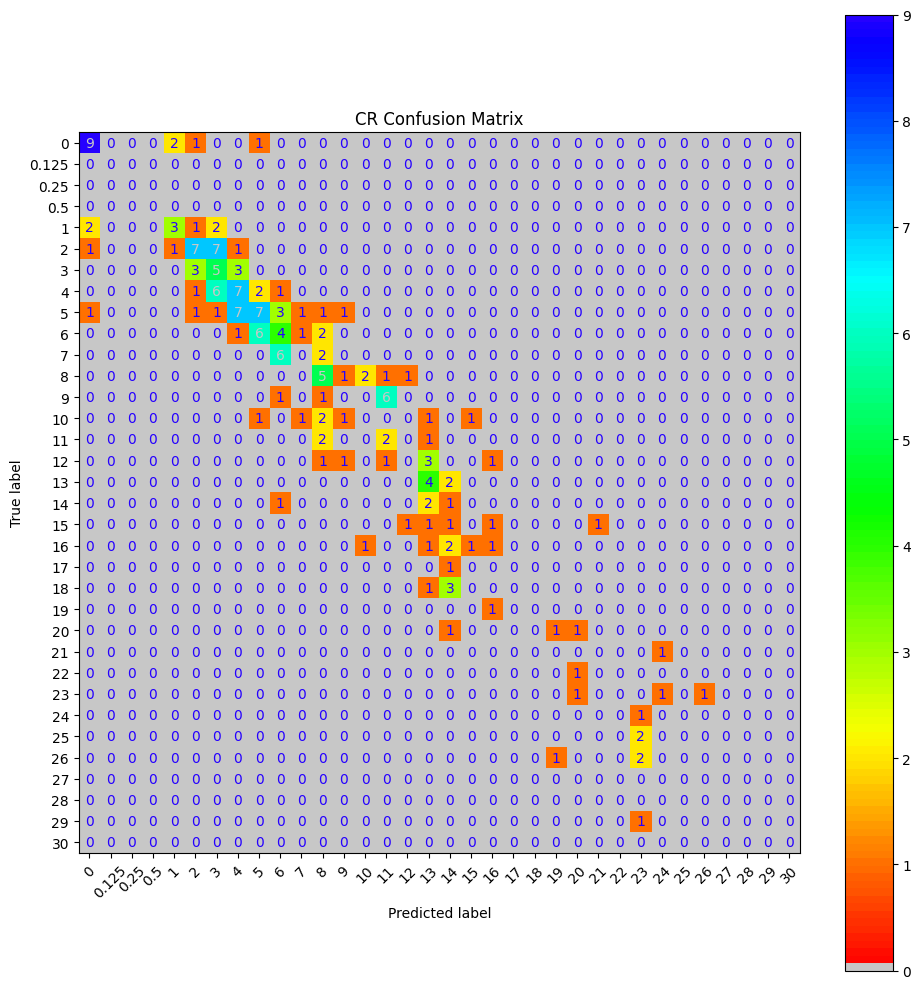

In [177]:
with torch.no_grad(): # we don't need gradients in the testing phase
    y_test = []
    y_pred = []
    cm = None
    for name,numeric,cat1,cat2,cat3,cat4,target in test_loader:
        # Move test data to GPU as well
        numeric = numeric.to(device)
        cat1 = cat1.to(device)
        cat2 = cat2.to(device)
        cat3 = cat3.to(device)
        cat4 = cat4.to(device)
        target = target.to(device)

        outputs = model(numeric,cat1,cat2,cat3,cat4)

        _, predictions = torch.max(outputs,1) # 1 is the dimension
        y_test = np.concatenate([y_test,target.cpu().numpy()])
        y_pred = np.concatenate([y_pred,predictions.cpu().numpy()])\

    cm = confusion_matrix(y_true=y_test,y_pred=y_pred,labels=crs)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=crs)
    
    
    n_correct = (y_test == y_pred).sum().item()
    n_samples = y_test.shape[0]
    accuracy = 100 * n_correct / n_samples
    print(f'accuracy = {accuracy:.2f}% ({n_correct}/{n_samples})')

    oldcolors = mpl.colormaps['hsv']
    newcolors = oldcolors(np.linspace(0,.70, 128))
    val = 200
    grey = np.array([val/256, val/256, val/256, 1])
    newcolors[:1, :] = grey
    cmap = ListedColormap(newcolors)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(ax=ax,cmap=cmap)
    plt.xticks(rotation=45)
    plt.title("CR Confusion Matrix")
    
    plt.tight_layout()